In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
from rich import print

In [2]:
size = (224, 224)
classes = ['Autistic', 'Non_Autistic']

In [3]:
def ld_img(path):
    img = cv2.imread(path)
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    norm_img = cv2.resize(img, size) / 255.0

    folder_name = os.path.basename(os.path.dirname(path))
    label = classes.index(folder_name) if folder_name in classes else -1

    return norm_img, label


def ld(folder_path, max_workers=8):
    paths = glob.glob(os.path.join(folder_path, '**', '*.[jp][pn][g]'), recursive=True)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(ld_img, paths), total=len(paths), desc="Read"))

    images, labels = zip(*results) if results else ([], [])
    print(f'Loaded {len(images)} images from {folder_path}')
    return np.array(images), np.array(labels)

In [4]:
X_train, y_train = ld('datasets/AutismDataset/train')
X_val, y_val = ld('datasets/AutismDataset/valid')
X_test, y_test = ld('datasets/AutismDataset/test')

Read: 100%|██████████| 2540/2540 [00:10<00:00, 253.39it/s]


Loaded 2540 images from datasets/AutismDataset/train

Read: 100%|██████████| 100/100 [00:00<00:00, 228.62it/s]


Loaded 100 images from datasets/AutismDataset/valid

Read: 100%|██████████| 300/300 [00:01<00:00, 209.78it/s]


Loaded 300 images from datasets/AutismDataset/test

In [5]:
print(f'{X_train.shape} | {y_train.shape} | {X_val.shape} | {y_val.shape} | {X_test.shape} | {y_test.shape}')

(2540, 224, 224, 3) | (2540,) | (100, 224, 224, 3) | (100,) | (300, 224, 224, 3) | (300,)

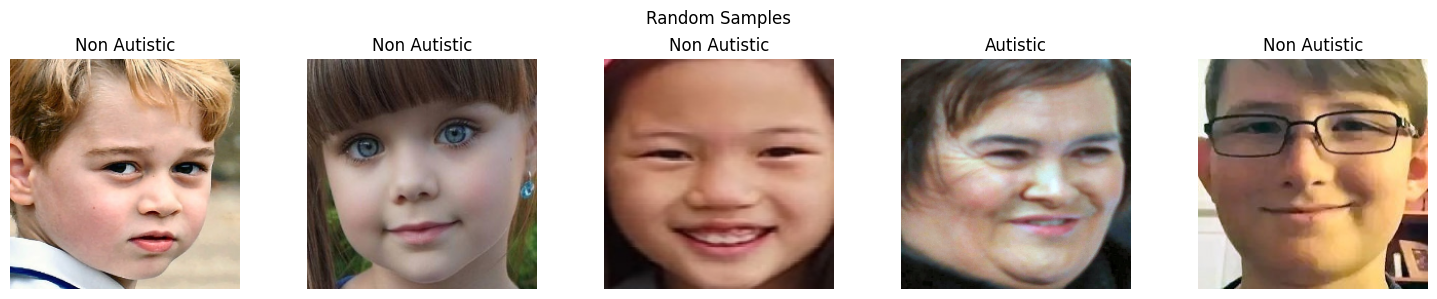

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(f"{'Autistic' if y_train[idx] == 0 else 'Non Autistic'}")
    ax.axis('off')
plt.suptitle('Random Samples')
plt.tight_layout()
plt.show()

In [9]:
print(X_train.shape)

(2540, 224, 224, 3)

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [10]:
model = keras.Sequential([
    layers.Input(shape=(size[0], size[1], 3)),
    layers.Conv2D(24, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 1, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

In [11]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 32)   │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        46,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from sklearn.model_selection import train_test_split
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [14]:
print(X_val.shape, y_val.shape, X_train.shape, y_train.shape)

(1270, 224, 224, 3)
(1270,)
(2540, 224, 224, 3)
(2540,)

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - accuracy: 0.5850 - loss: 0.6750 - val_accuracy: 0.6976 - val_loss: 0.6346
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 416ms/step - accuracy: 0.6791 - loss: 0.6170 - val_accuracy: 0.7331 - val_loss: 0.5730
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.6957 - loss: 0.5728 - val_accuracy: 0.7433 - val_loss: 0.5414
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.7110 - loss: 0.5580 - val_accuracy: 0.7425 - val_loss: 0.5190
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.7327 - loss: 0.5319 - val_accuracy: 0.7614 - val_loss: 0.5001
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step - accuracy: 0.7366 - loss: 0.5210 - val_accuracy: 0.7740 - val_loss: 0.4869
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 378ms/step - accuracy: 0.7524 - loss: 0.5054 - val_accuracy: 0.7748 - val_loss: 0.4732
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 381ms/step - accuracy: 0.7661 - loss: 0.4915 - val_accu

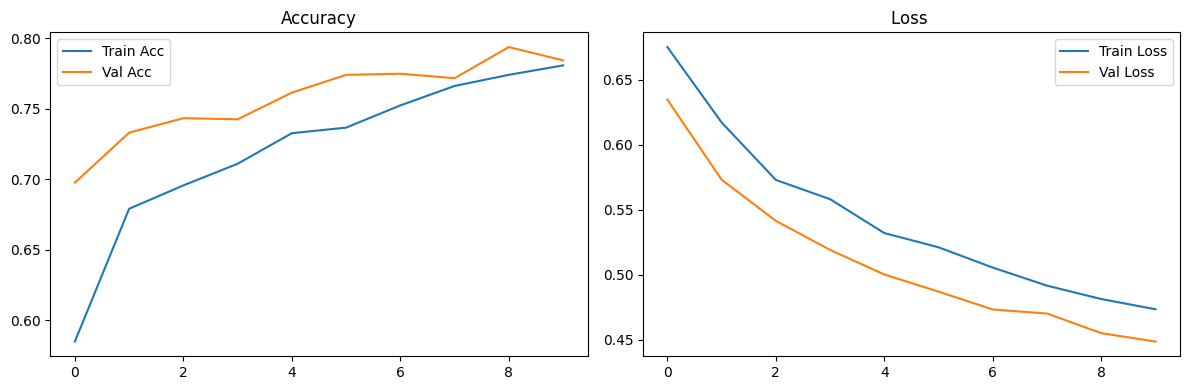

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='Train Acc')
ax1.plot(history.history['val_accuracy'], label='Val Acc')
ax1.set_title('Accuracy')
ax1.legend()
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Loss ')
ax2.legend()
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


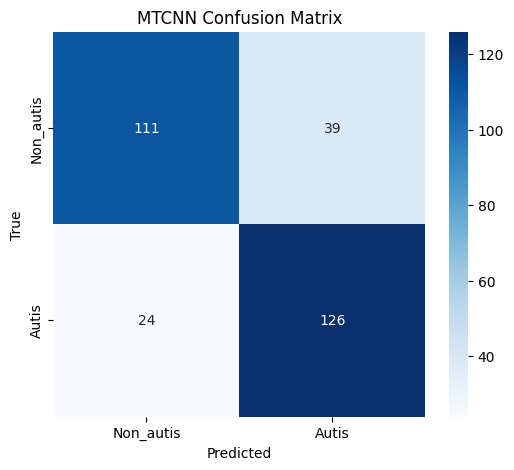

In [23]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non_autis', 'Autis'], yticklabels=['Non_autis', 'Autis'])
plt.title('MTCNN Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [24]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Non_autis', 'Autis']))

Classification Report:

precision    recall  f1-score   support

   Non_autis       0.82      0.74      0.78       150
       Autis       0.76      0.84      0.80       150

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300

In [25]:
idx = np.random.randint(0, len(X_test))
print(X_test[idx].shape)

(224, 224, 3)

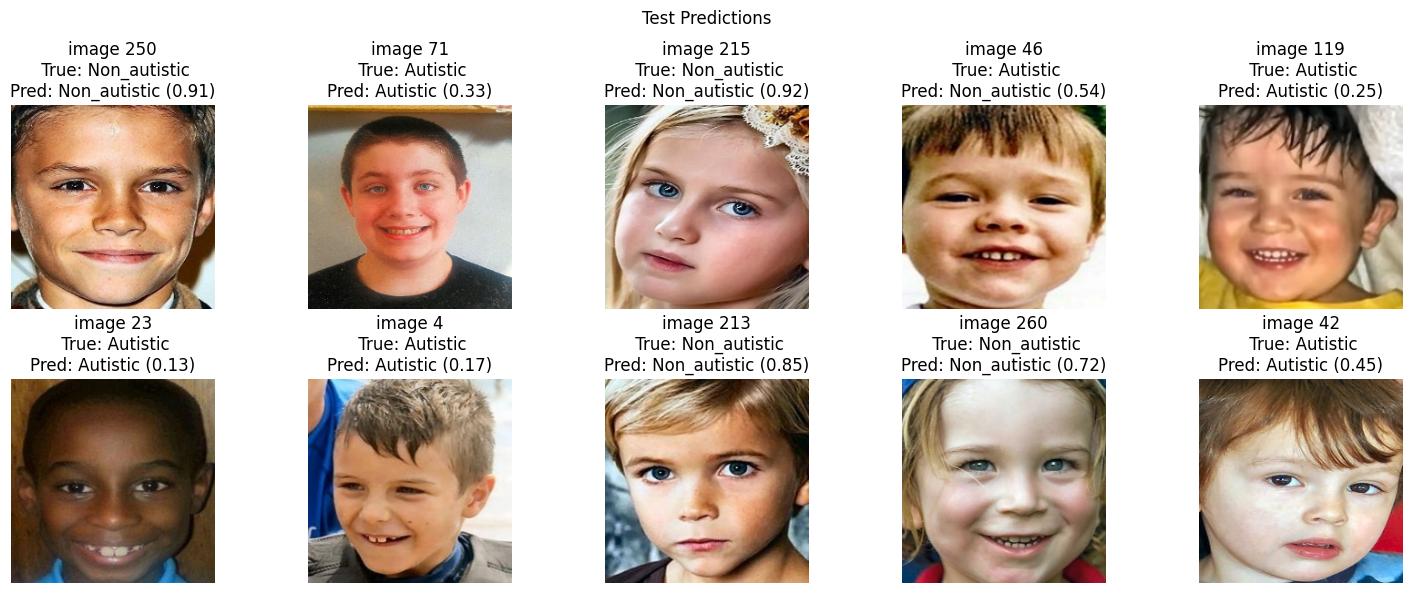

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax in axes.flat:
    idx = np.random.randint(0, len(X_test))
    pred = model.predict(X_test[idx:idx+1], verbose=None)[0][0]
    ax.imshow(X_test[idx])
    ax.set_title(f"image {idx}\n True: {'Autistic' if y_test[idx] == 0 else 'Non_autistic'}\nPred: {'Autistic' if pred < 0.5 else 'Non_autistic'} ({pred:.2f})")
    ax.axis('off')
plt.suptitle('Test Predictions')
plt.tight_layout()
plt.show()

In [29]:
model.save('model/autism_cnn_model(test4val).h5')